In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import glob
import pickle as pkl
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

2024-06-20 09:58:05.785866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:58:05.785965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:58:05.949918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data analysis

In [3]:
train_images = '/kaggle/input/basedir/base_dir/train_dir'
classes = os.listdir(train_images)
for class_name in classes:
    class_path = os.path.join(train_images, class_name)
    print(f'Class {class_name} has {len(os.listdir(class_path))} images')

Class mel has 5920 images
Class vasc has 5290 images
Class df has 4410 images
Class nv has 5954 images
Class bkl has 5920 images
Class akiec has 5217 images
Class bcc has 5858 images


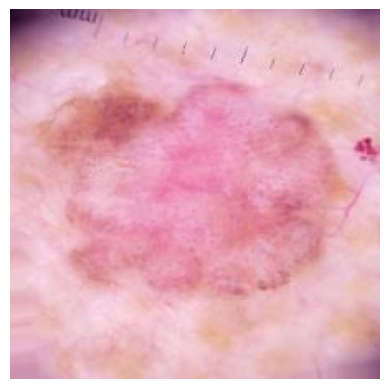

Image dimensions: 224 x 224


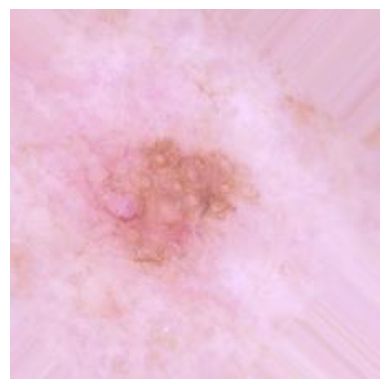

Image dimensions: 224 x 224


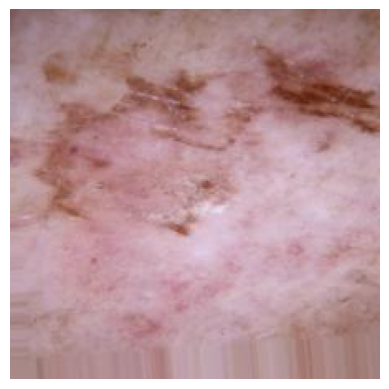

Image dimensions: 224 x 224


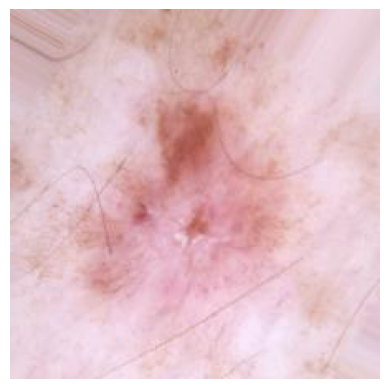

Image dimensions: 224 x 224


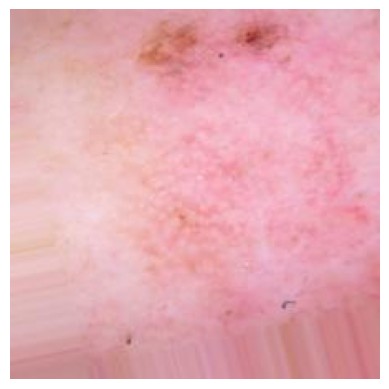

Image dimensions: 224 x 224


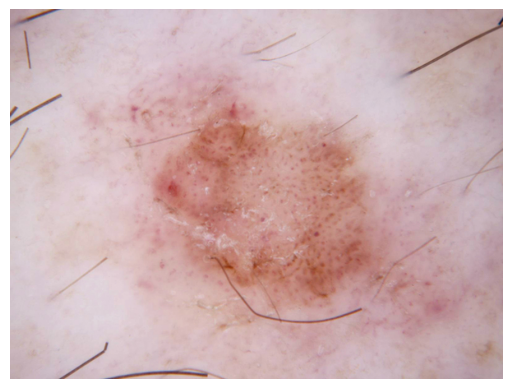

Image dimensions: 600 x 450


In [4]:
sample = '/kaggle/input/basedir/base_dir/train_dir/akiec'

files = os.listdir(sample)
count = 5
j = 0
for i in files:
    if j > count:
        break
    img_path = os.path.join(sample, i)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    width, height = img.size
    print(f"Image dimensions: {width} x {height}")
    j += 1

## Loading Data

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TrainDatagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
                                 )

ValidationDatagen = ImageDataGenerator(rescale = 1./255)

train_dir = '/kaggle/input/basedir/base_dir/train_dir'
val_dir = '/kaggle/input/basedir/base_dir/val_dir'

train = TrainDatagen.flow_from_directory(train_dir,
                                        shuffle = True,
                                        target_size = (224, 224), 
                                        class_mode='categorical',
                                        batch_size = 8
                                        )

validation = ValidationDatagen.flow_from_directory(train_dir,
                                        shuffle = True,
                                        target_size = (224, 224), 
                                        class_mode='categorical',
                                        batch_size = 8
                                        )

Found 38569 images belonging to 7 classes.
Found 38569 images belonging to 7 classes.


## Display images with labels

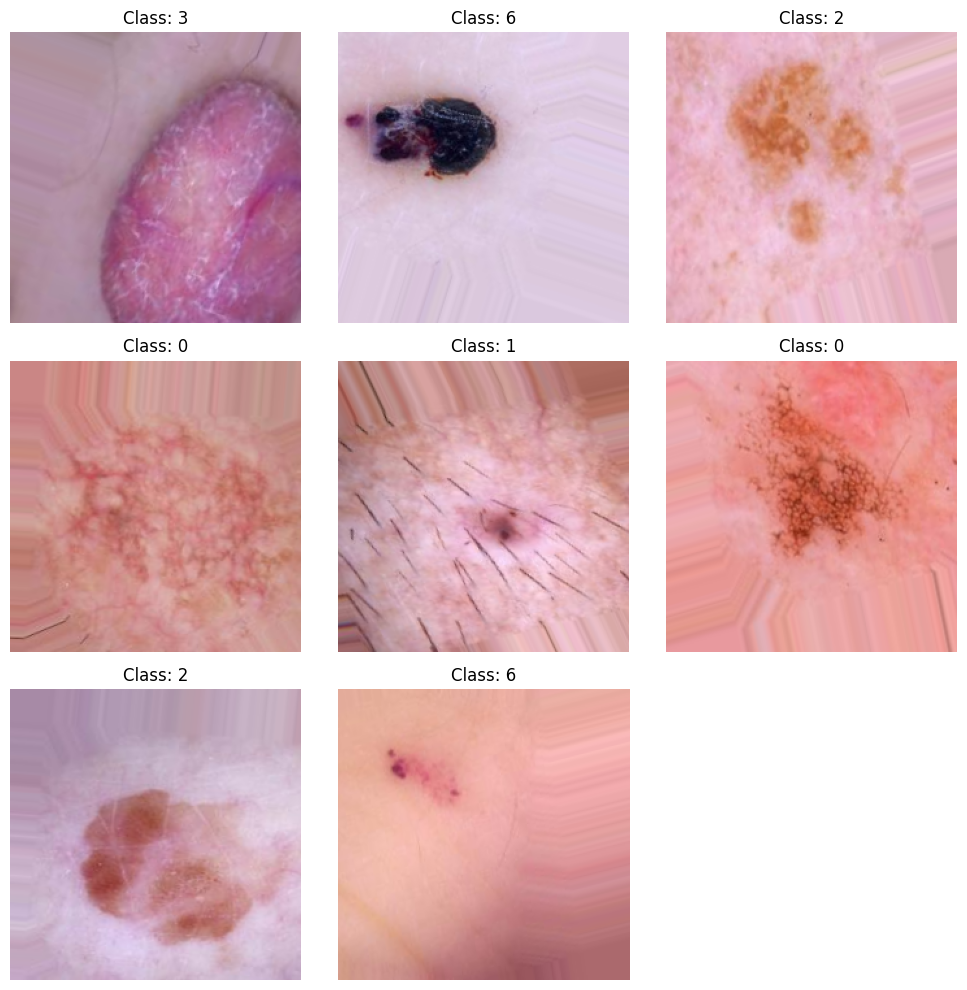

In [12]:
x_batch, y_batch = next(train)

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    class_index = np.argmax(y_batch[i])
    plt.title(f'Class: {class_index}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Neural Network

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  

In [ ]:
model.summary()

## Callbacks

In [8]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.90:
            print(f"\nReached 90% accuracy at epoch {epoch+1}, stopping training!")
            self.model.stop_training = True

checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.weights.keras', 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      save_weights_only = False)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=3, 
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, 
                                       patience=2, 
                                       min_lr=1e-6)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#model.fit(train, epochs = 20, validation_data = validation)

In [ ]:
#model.save('skincancer.h5')

## Transfer Learning

### Dense Net

In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

model = Model.Sequential()

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(7, activation= 'softmax'))

for layer in base_model.layers:
    layer.trainable = False

dense_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-06-21 02:37:52.739382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 02:37:52.739479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 02:37:52.876053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: type object 'Model' has no attribute 'Sequential'

In [ ]:
hist = dense_net_model.fit(train, epochs = 20, validation_data = validation, callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/4822 ━━━━━━━━━━━━━━━━━━━━ 41:03:52 31s/step - accuracy: 0.2500 - loss: 1.6709

I0000 00:00:1718878274.007391     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718878274.076904     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4821/4822 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5896 - loss: 1.0711

W0000 00:00:1718879087.084911     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4822/4822 ━━━━━━━━━━━━━━━━━━━━ 994s 200ms/step - accuracy: 0.5896 - loss: 1.0710 - val_accuracy: 0.7143 - val_loss: 0.7346 - learning_rate: 0.0010
Epoch 2/20
 555/4822 ━━━━━━━━━━━━━━━━━━━━ 7:19 103ms/step - accuracy: 0.7078 - loss: 0.7599

NameError: name 'history' is not defined

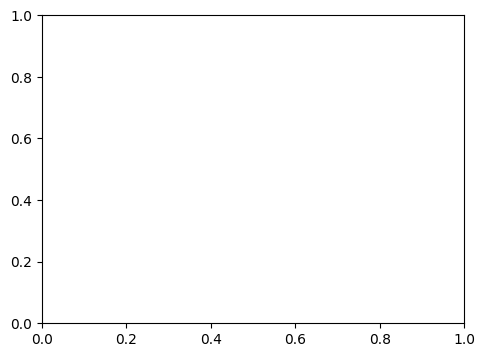

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
dense_net_model.save('skincancer2.keras')

In [17]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/model_checkpoint.weights.keras')

In [20]:
loss, accuracy = model.evaluate(validation)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

   5/4822 ━━━━━━━━━━━━━━━━━━━━ 3:01 38ms/step - accuracy: 0.9308 - loss: 0.2200  

W0000 00:00:1718887740.275273     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4822/4822 ━━━━━━━━━━━━━━━━━━━━ 138s 26ms/step - accuracy: 0.8495 - loss: 0.3850
Validation Loss: 0.3853
Validation Accuracy: 0.8494


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = '/image_path'
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

model = load_model('model_checkpoint.weights.keras')

predictions = model.predict(img_array)

class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanoma', 'Melanocytic nevi', 'Vascular lesions']

predicted_class_index = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_name} with probability {predictions[0][predicted_class_index]:.4f}')
